<a href="https://colab.research.google.com/github/s00ny0ung/s00ny0ung_studyfolio/blob/gh-pages/K_%EC%B5%9C%EC%A0%91%EA%B7%BC_%EC%9D%B4%EC%9B%83(KNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 임포트
실습에 필요한 라이브러리를 임포트합니다.

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 그래프 출력을 위해 선언합니다.
%matplotlib inline
# sklearn 모델의 동일한 결과 출력을 위해 선언합니다.
np.random.seed(5)

# 데이터 불러오기 (학습 데이터, 테스트 데이터)
농구 선수 포지션 예측하기의 학습 데이터 및 테스트 데이터를 로드합니다.

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/wikibook/machine-learning/2.0/data/csv/basketball_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/wikibook/machine-learning/2.0/data/csv/basketball_test.csv")

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/wikibook/machine-learning/2.0/data/csv/basketball_stat.csv")

In [ ]:
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [ ]:
#현재 데이터에서 포지션의 개수를 확인한다.
df.Pos.value_counts()

C     50
SG    50
Name: Pos, dtype: int64

In [ ]:
#데이터 시각화

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'STL and 2P in 2d plane')

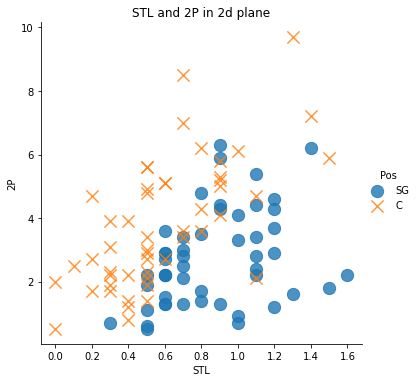

In [ ]:
#스틸, 2점슛 데이터 시각화
sns.lmplot('STL','2P', data=df,fit_reg=False, scatter_kws={"s":150}, markers=["o","x"],hue="Pos")
plt.title('STL and 2P in 2d plane')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'BLK and 3P in 2d plane')

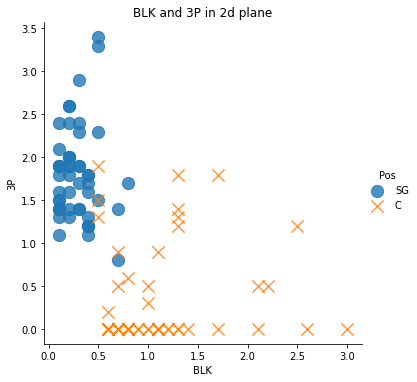

In [ ]:
#블로킹, 3점슛 데이터 시각화
sns.lmplot('BLK','3P', data=df,fit_reg=False, scatter_kws={"s":150}, markers=["o","x"],hue="Pos")
plt.title('BLK and 3P in 2d plane')

In [ ]:
df.head()

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5


In [ ]:
#데이터 클렌징 - 2점슛, 어시스트, 스틸 속성이 슈팅가드와 센터를 분류하는데 크게 도움이 되지 않는다는 점을 파악
#분별력이 없는 특징을 데이터에서 제거
df.drop(['2P','AST','STL'],axis=1, inplace=True)


In [ ]:
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


In [ ]:
#데이터나누기
#학습데이터와 테스트데이터 분리 : train_test_split 사용

#사이킷런의 train_test_split을 상ㅇ하면 코드 한줄로 손쉽게 데이터를 나눌 수 있다.
from sklearn.model_selection import train_test_split

In [ ]:
#20%는 테스트데이터, 80% 학습 데이터
train, test = train_test_split(df, test_size=0.2)

In [ ]:
test.shape

(20, 5)

In [ ]:
train.shape

(80, 5)

In [ ]:
#최적의 knn 파라미터 찾기 - k 파라미터
#사이킷런 cross_val_score 사용하기 - kfold 교차검증

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
max_k_range = train.shape[0]//2
k_list = []
for i in range(3, max_k_range,2):
  k_list.append(i)

cross_validation_scores = []
x_train = train[['3P','BLK', 'TRB']] #학습데이터
y_train = train[['Pos']] #정답데이터(레이블)

In [ ]:
#사이킷런 cross_val_score 사용하기 - kfold 교차검증
#교차 검증(10-fold)을 각 k를 대상으로 수행해 검증 결과를 저장
for k in k_list:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, x_train, y_train.values.ravel(),cv=10,scoring='accuracy') #cv는 폴드수 
  cross_validation_scores.append(scores.mean())

cross_validation_scores

[0.8875,
 0.875,
 0.875,
 0.8625,
 0.875,
 0.8625,
 0.8625,
 0.8625,
 0.8625,
 0.875,
 0.875,
 0.875,
 0.8625,
 0.8625,
 0.85,
 0.85,
 0.825,
 0.8,
 0.8]

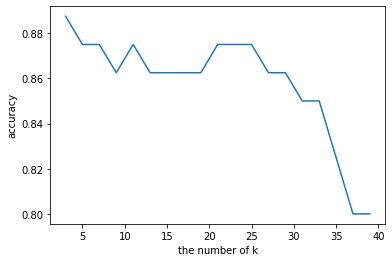

In [ ]:
#k에 따른 정확도를 시각화
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('accuracy')
plt.show()

In [ ]:
#시각화를 통해 최적의 k가 3인 것을 알 수 있다.
#가장 예측율이 높은 k를 선정
k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print("The best number of k : " + str(k))

The best number of k : 3


In [ ]:
#모델 테스트
#3점슛, 블로킹, 리바운드 - 3개의 속성으로 knn모델을 학습해서 테스트 진행

#라이브러리 임포트
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=k)

#학습에 사용될 속성을 지정
x_train = train[['3P','BLK','TRB']]
#선수 포지션을 예측할 값으로 지정
y_train = train[['Pos']]

#knn 모델 학습
knn.fit(x_train, y_train.values.ravel())

#테스트 데이터에서 분류를 위해 사용될 속성을 지정
x_test = test[['3P','BLK','TRB']]
#선수 포지션에 대한 정답을 지정
y_test = test[['Pos']]

#테스트 시작
pred = knn.predict(x_test)

#모델 예측 정확도 출력
print("accuracy : "+ str(accuracy_score(y_test.values.ravel(), pred)))

accuracy : 0.95


In [ ]:
comparison = pd.DataFrame({'prediction': pred, 'ground_truth':y_test.values.ravel()})

In [ ]:
comparison

,prediction,ground_truth
0,C,C
1,SG,SG
2,C,C
3,SG,SG
4,C,C
5,C,C
6,C,C
7,SG,SG
8,SG,SG
9,C,C
